In [2]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

In [3]:
def display_mfcc(song):
    y,_ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

C:\Users\Bryan\anaconda3\envs\myenv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Bryan\anaconda3\envs\myenv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


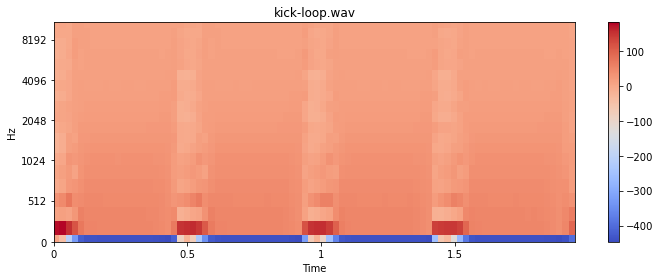

In [9]:
display_mfcc('kick-loop.wav')

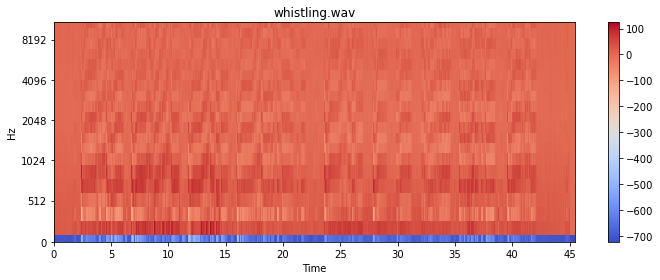

In [10]:
display_mfcc('whistling.wav')

C:\Users\Bryan\anaconda3\envs\myenv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Bryan\anaconda3\envs\myenv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


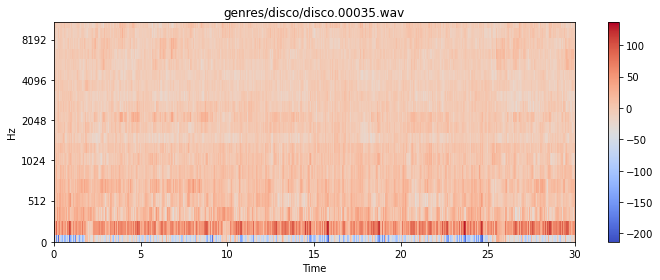

In [4]:
display_mfcc('genres/disco/disco.00035.wav')

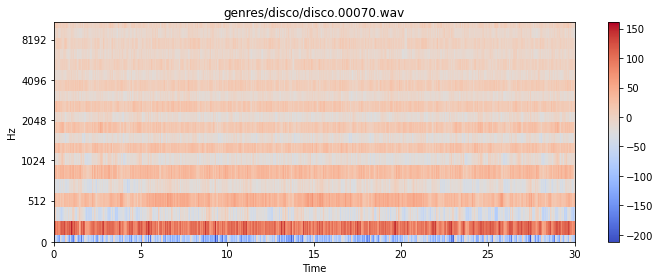

In [5]:
display_mfcc('genres/disco/disco.00070.wav')

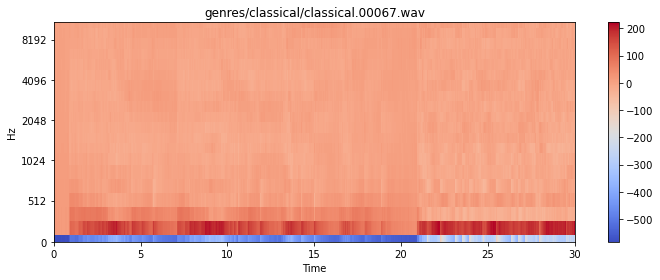

In [6]:
display_mfcc('genres/classical/classical.00067.wav')

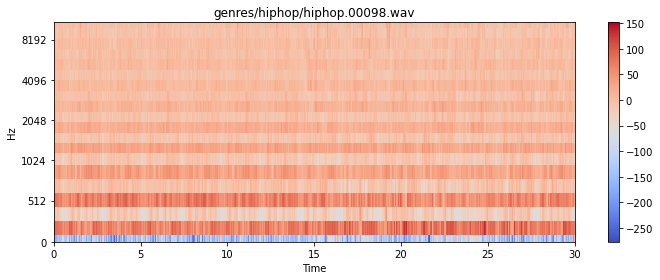

In [7]:
display_mfcc('genres/hiphop/hiphop.00098.wav')

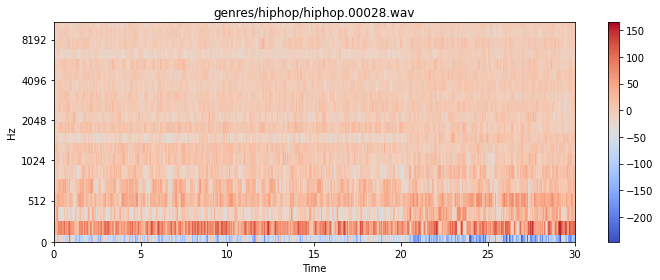

In [8]:
display_mfcc('genres/hiphop/hiphop.00028.wav')

In [16]:
def extract_features_song(f):
    y, _ = librosa.load(f)
    
    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))
    
    return np.ndarray.flatten(mfcc)[:25000]

In [17]:
def generate_features_and_labels():
    all_features = []
    all_labels = []
    
    genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files),genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)
    
    #convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [18]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [22]:
print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# last column has genre, turn it into unique ids
alldata = np.column_stack((features,labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata)*training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))

train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(np.shape(train_input))
print(np.shape(train_labels))

(1000, 25000)
(1000, 10)
(800, 25010)
(200, 25010)
(800, 25000)
(800, 10)


In [26]:
model = Sequential([
    Dense(100, input_dim=np.shape(train_input)[1]),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
    ])

model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])
print(model.summary())

model.fit(train_input, train_labels, epochs=10, batch_size=32, validation_split=0.2)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print("Done!")
print("Lose: %.4f, accuracy: %.4f" % (loss, acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2500100   
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 2,501,110
Trainable params: 2,501,110
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
20/20 [==============================] - 1s 52ms/step - loss: 2.1581 - accuracy: 0.2984 - val_loss: 1.9095 - val_accuracy: 0.2937
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 1.4603 - accuracy: 0.4812